## Fashion MNIST

In this jupyter notebook I will implement a ML learning algorithm to solve the Fashion MNIST classification problem. In this case I'll use SVM, since its a powerful algorithm a works well with this dataset (even though its pretty large).

### Importing dataset and the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data  = pd.read_csv('fashion-mnist_test.csv')

Since its already split and ordered, we can proceed. Lets just do a quick check

In [2]:
#Checking for nulls, always a good practice
train_data.isnull().sum()
test_data.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

### Splitting data and scaling the size of the dataset

Lets note that the size of the dataset its pretty big (maybe to much for what is needed in this case).
So, in order to perform a good model selection we have to do a resize, we cant just brute force it.
This will also be good to perform hyperparameter tuning in an efficient way. As we now, accuracy is good, but youre time as a programmer is also valuable:)

I'll start with a reasonable amount of data.

In [3]:
#Splitting the data (we start with 10000 just to give us an idea of which model to pick)
X_train    = train_data.iloc[:10000, 1:].values
y_train    = train_data.iloc[:10000, 0].values
X_test     = test_data.iloc[:, 1:].values
y_test     = test_data.iloc[:, 0].values

### Choosing the model
For this problem I'll try 3 different models:
* Support Vector Machine - Pretty robust and works very well for classification problems and the sparsity of the data its a plus
* Random forest tree - It works pretty well in a lot problems (including this one) and its pretty fast
* K nearest neighbors - Its good for multiclass classification and works well with large datasets.

We wont use Logistic regression nor naive bayes, since we dont want to know the exact probabity. Also, Even though logistic regression works fine for multiple labels predictions, it works the best when is just binary

NOTE: I tried a simple LR model in another file, and it is a good model, but as we'll see, it gets outperformed by other models.


In [7]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.8423

In [8]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.8218

In [9]:
#SVM
from sklearn.svm import SVC
classifier = SVC(gamma="scale", kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.8614

Since SVM was the best model for this case, I'll pick that model for further analysis and tuning

### Hyperparameter tuning of SVM

As we know, 86.14% its a very good score. But we can improve that score while improving the efficiency

But first, lets feed the model with some more data...

In [10]:
X_train    = train_data.iloc[:15000, 1:].values
y_train    = train_data.iloc[:15000, 0].values

Let's start with the GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV



params = {
 		  'C': [0.01,0.1,1,10,50,100],
 		  'kernel': ['rbf','sigmoid'],
 		  'gamma':['scale']
 		 }
classifier = SVC(**params, probability=True)

classifier_opt = GridSearchCV(classifier, param_grid=params, scoring='neg_log_loss', n_jobs=-1, cv=2, verbose=10)
classifier_opt.fit(X_train, y_train)

classifier_opt.best_params_

In [11]:
classifier = SVC(gamma="scale", kernel = 'rbf', C=10, random_state = 0)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.883

In [12]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(classifier, X_train, y_train, cv=3)
print(f"Mean accuracy:  {cv_results['test_score'].mean()}")

Mean accuracy:  0.8776666666666667


### PCA (As an extra step)
Since our data has +700 features (dimensions) we might as well see what we can do about it. It could improve our performance and accuracy (or let it almost the same). So there's no reason to avoid a PCA (in this case).

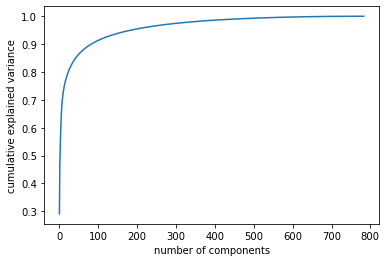

In [13]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The explained variance starts to flat around 400-500, so lets use the first 400 components of our dataset to fit the model again

In [14]:
pca = PCA(n_components=400)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)


### Results

In [15]:
classifier = SVC(gamma='scale',kernel='rbf',C=10)
classifier.fit(X_train,y_train)
preds = classifier.predict(X_test)

print(f"Test acc {accuracy_score(preds,y_test)}")

Test acc 0.883


Not that much of a improvemen in accuracy, but sure it was faster. So lets call it a victory :)

### What to improve?

* We could do graph that tells us the accuracy in function of the amount of data given to the model, in order to know how much data we can give to the model in order to be as fast as possible
* It would be nice to set a constant amount of data. The same amount of data when we are choosing our model as when we are tuning the best model
* We can do a better work narrowing down the optimal value for C 